# How far are people living from a public park in Antwerp?

## GeoPandas

In [1]:
%matplotlib inline

In [2]:
import geopandas

In [3]:
import pandas as pd
pd.options.display.max_rows = 4

In [4]:
import matplotlib.pyplot as plt

## The Urban Atlas data for Antwerp

**Urban Atlas** is providing pan-European comparable land use and land cover data for Large Urban Zones (http://www.eea.europa.eu/data-and-maps/data/urban-atlas). The shapefile for Antwerp I am using here as an example can be downloaded [here](http://www.eea.europa.eu/data-and-maps/data/urban-atlas/belgium/be002l_antwerpen.zip). 

In [5]:
data = geopandas.read_file('data/be002l_antwerpen.shp')

In [6]:
data

,CITIES,CODE,ITEM,LUZ_OR_CIT,PROD_DATE,SHAPE_AREA,SHAPE_LEN,geometry
0,Antwerpen,11230,Discontinuous Low Density Urban Fabric (S.L. :...,BE002L,2009,25923.449763,644.721466,"POLYGON ((3942088.635515752 3166425.799341096,..."
1,Antwerpen,12220,Other roads and associated land,BE002L,2009,34164565.897200,8223078.675070,"POLYGON ((3941308.001901154 3165895.295323509,..."
...,...,...,...,...,...,...,...,...
16979,Antwerpen,50000,Water bodies,BE002L,2009,22418.201100,1386.257740,"POLYGON ((3932236.329188233 3121582.694353936,..."
16980,Antwerpen,50000,Water bodies,BE002L,2009,15674.852364,998.105315,"POLYGON ((3933859.550966764 3121550.085349663,..."


Checking the coordinate reference system:

In [7]:
data.crs

{'init': 'epsg:3035'}

We convert the data to the Belgian Lambert system:

In [8]:
data = data.to_crs(epsg=31370)

Taking a look at the surface of the different land use patches:

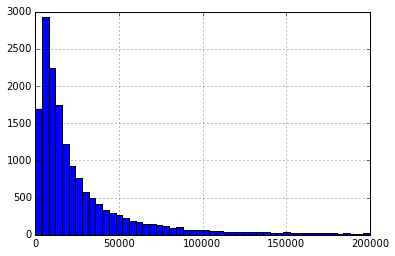

In [9]:
data.geometry.area.hist(bins=50, range=(0,0.2e6))

Plotting the shapes with coloring based on the column with the land use:

In [10]:
data = data[((data.bounds['minx'] < 160000) & (data.bounds['maxx'] > 150000)
             & (data.bounds['miny'] < 215000) & (data.bounds['maxy'] > 208000))]

In [11]:
# remove some categories for easier plotting
data = data[data['ITEM'] != 'Water bodies']
data = data[data['ITEM'] != 'Other roads and associated land']

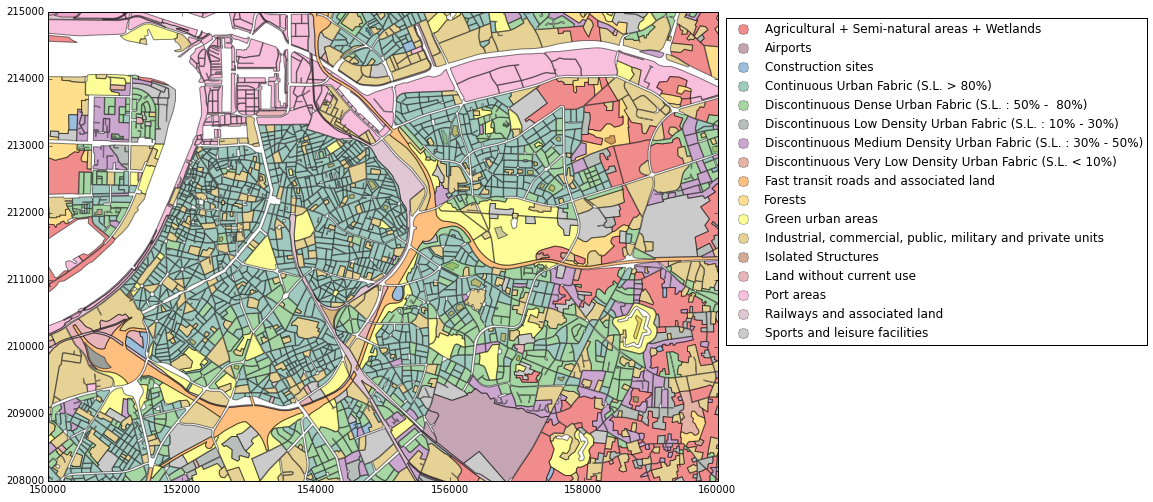

In [14]:
ax = data.plot(column='ITEM', legend=True, figsize=(12,10))
ax.set_xlim(150000, 160000)
ax.set_ylim(208000, 215000)
# to put the legend next to the figure (otherwise overlaps)
ax.get_legend().set_bbox_to_anchor((1.65, 1))

### We are interested in the green areas

For this analysis, we are specifically interested in the land use *'Green urban areas'*. To get those, filtering can be done as with normal dataframes:

In [15]:
green_areas = data[data['ITEM']=='Green urban areas']

To visualize, we also read in a streets shape file:

In [16]:
streets = geopandas.read_file("data/layer_streets.shp")

(208000, 215000)

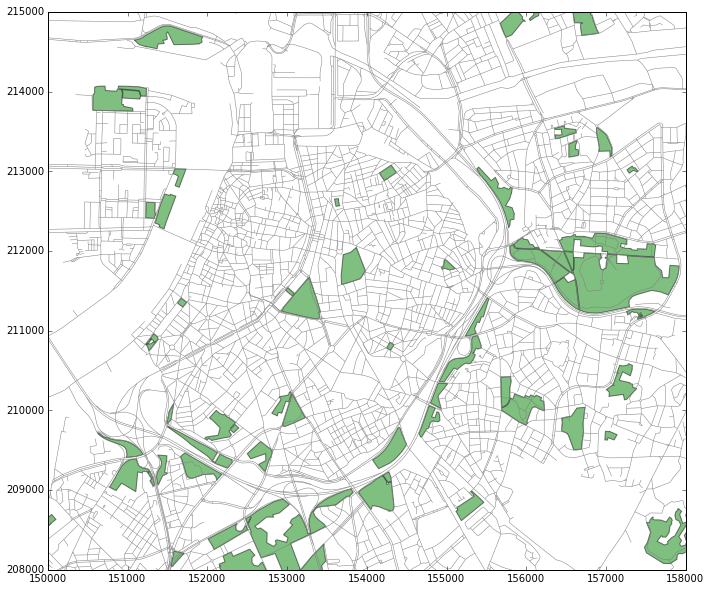

In [17]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'aspect':'equal'})
streets.plot(ax=ax, color="grey", linewidth=0.5)
green_areas.plot(ax=ax, color='green')
ax.set_xlim(150000, 158000)
ax.set_ylim(208000, 215000)

## Where do people live? 

We get the address locations from the *Centraal Referentieadressenbestand* (https://www.agiv.be/producten/crab):

In [19]:
addresses = geopandas.read_file('data/layer_CRAB.shp')

Selecting addresses in the city center:

In [20]:
x = addresses.geometry.apply(lambda p: p.x)
y = addresses.geometry.apply(lambda p: p.y)

In [21]:
addresses = addresses[(x < 156000) & (x > 152000) & (y < 213000) & (y > 210000)]

(210000, 213000)

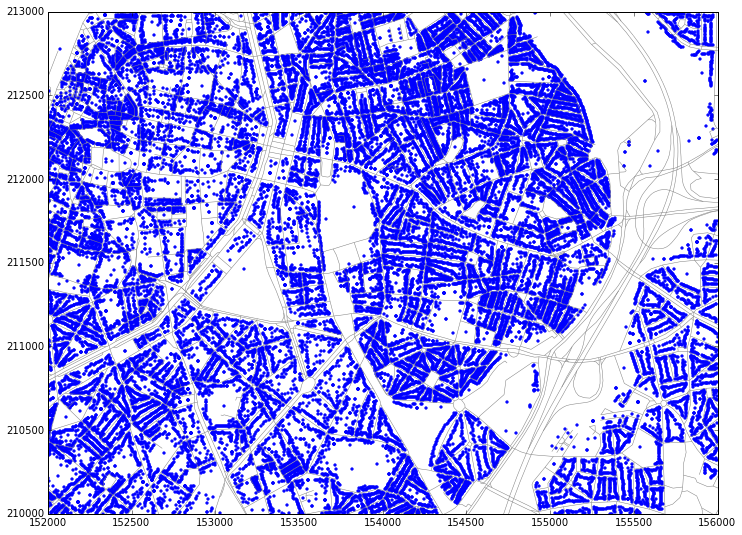

In [22]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'aspect':'equal'})
streets.plot(ax=ax, color="grey", linewidth=0.5)
addresses.plot(ax=ax, color='blue', markersize=5)
ax.set_xlim(152000, 156000)
ax.set_ylim(210000, 213000)

## Question: what is the distance to the nearest green area for all adresses?

Considering only the green areas of at least 1 ha:

In [23]:
urban_green = data[(data['ITEM']=='Green urban areas') & (data.geometry.area > 10000)]

Calculating the minimal distance to a green area for each address point:

In [24]:
def urban_green_dist(point, urban_green):
    return urban_green.geometry.distance(point).min()

In [25]:
addresses['min_distance'] = addresses.geometry.apply(lambda x: urban_green_dist(x, urban_green))

By supplying the `column` keyword to `plot`, we can indicate that the objects have to be colored depending on the values in that column:

(210000, 213000)

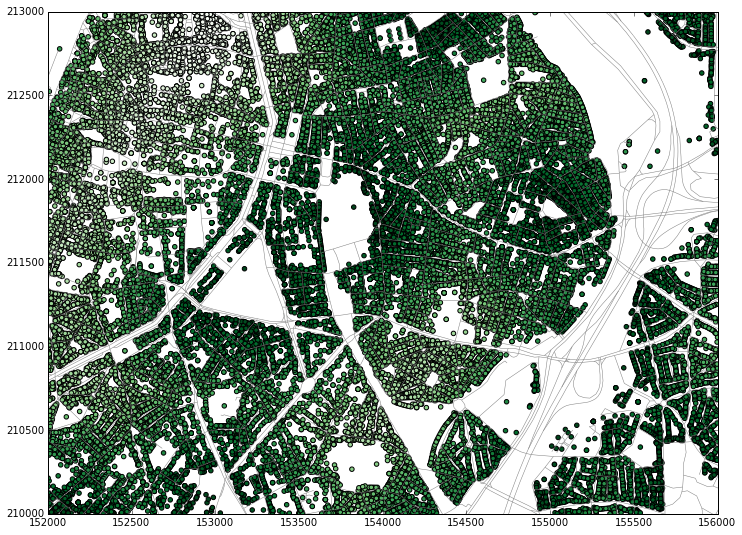

In [26]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'aspect':'equal'})
streets.plot(ax=ax, color="grey", linewidth=0.5)
addresses.plot(ax=ax, column='min_distance', colormap='Greens_r', markersize=20)
ax.set_xlim(152000, 156000)
ax.set_ylim(210000, 213000)

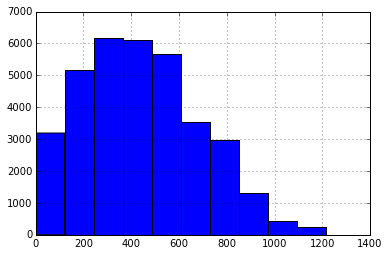

In [27]:
addresses['min_distance'].hist()

Cumulative plot: